## Assignment 1 Model Fitting with Maximum Likelihood 
* The purpose of this assignment is to learn how to write a log likelihood function, fit models to data with maximum likelihood and to select among models using AIC and a validation set.  
* Along the way, we'll learn a bit about decision making models and response time data.  

### Due: Sunday 10/19

In [187]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import scipy
from scipy.optimize import minimize

from scipy.stats import norm

### A Perceptual Discrimination Task to Study Decision Making

This is actual data from my lab, which was published here:

Nunez, M. D., Vandekerckhove, J., & Srinivasan, R. (2017). How attention influences perceptual decision making: Single-trial EEG correlates of drift-diffusion model parameters. Journal of Mathematical Psychology, 76(Part B), 117–130. https://doi.org/10.1016/j.jmp.2016.03.003

Human subject were asked to discriminate the spatial frequency of Gabor patches (as shown below), embeded in noise.  Task difficulty was controlled by the difficulty of the discrimination.  Two Gabors with more similar spatial frequencies are harder to discriminate, especially when noise is added.  In each of 34 participant, The experiment was performed in Easy, Medium, and Hard blocks each consisting of with decreasing differences between the Gabor spatial frequencies.  

![](spatialfrequency.png)

The datafile ReactionTimeData.csv is for use in this homework. You can load it into your notebook using pandas using pandas. There are 3 variables in the file: 

* Subject - indicates a numeric subject id 
* Experimental Condition - Easy, Medium, Hard 
* Correct - 1 if correct 0 if incorrect 
* ResponseTime  - time from stimulus presentation to decision in units of millisecond 

#### Problem 1 Explore and Visualize the Data.  I recommend using this exercise to learn about seaborn. 
a. make a histogram of Response Time showing all 3 difficulty conditions in a single graph.
 
 

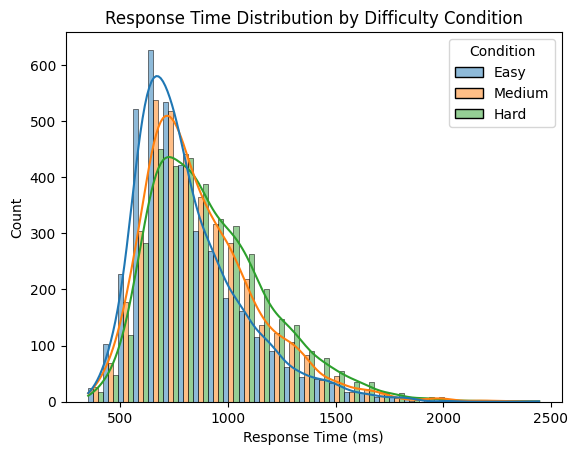

In [188]:
import pandas as pd
import seaborn as sns
df = pd.read_csv("ResponseTimeData.csv")

df.columns # checking column names cus idk them

sns.histplot(data=df, 
            x = "ResponseTime", 
            hue = "Condition",
            kde = True,
            hue_order= ["Easy", "Medium", "Hard"], 
            multiple = "dodge", 
            bins = 30)

plt.title("Response Time Distribution by Difficulty Condition")
plt.xlabel("Response Time (ms)")
plt.show()

b. make a bar graph showing the accuracy (proportion or percentage correct) in each condition.  

In [189]:
df.columns

Index(['Unnamed: 0', 'Subject', 'Condition', 'Correct', 'ResponseTime'], dtype='object')

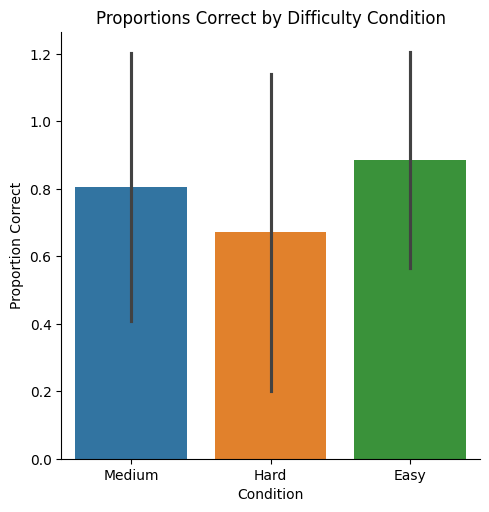

In [190]:
sns.catplot(data=df, 
            x= "Condition", 
            y= "Correct",
            kind= "bar",
            estimator = "mean", 
            errorbar= "sd", 
            hue= "Condition")
plt.ylabel("Proportion Correct")
plt.title("Proportions Correct by Difficulty Condition")
plt.show()

c. Make a boxplot that shows the distributions of each condition, with correct and incorrect trials separated. 

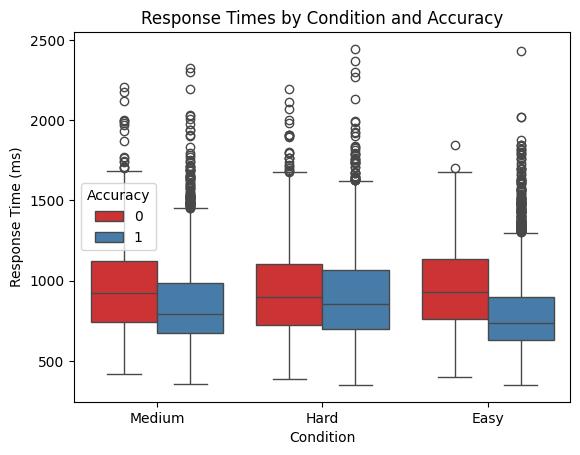

In [191]:
sns.boxplot(data=df,
            x= "Condition", # categorical variable grouping the data
            y= "ResponseTime", # numerical variable measured
            hue= "Correct", # seperates correct vs incorrect response times
            palette = "Set1") 
            # hue is color and differentiates data within each condition
plt.title("Response Times by Condition and Accuracy")
plt.ylabel("Response Time (ms)")
plt.legend(title="Accuracy")
plt.show()
            


d. Calculate the mean reaction time for each subject in each condition.  Make a histogram that shows the distribution of mean RT across subjects,showing all 3 conditions in a single graph. 

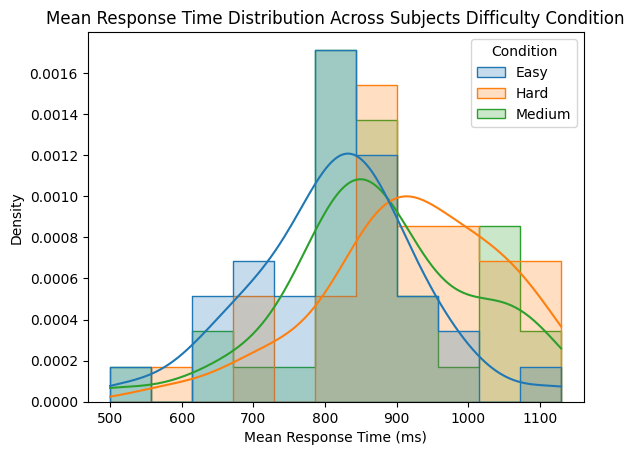

In [192]:
mean_response_times = df.groupby(["Subject", "Condition"])["ResponseTime"].mean().reset_index()
# make a mean RT data frame grouped by subject and condition
# reset_index() makes it a dataframe for plotting
# groupby first subject and condition, calcuate mean RT with each group!

# PLOT!
sns.histplot(data=mean_response_times,
            x= "ResponseTime",
            hue= "Condition",
            kde= True,
            element= "step",
            stat= "density")
plt.title("Mean Response Time Distribution Across Subjects Difficulty Condition")
plt.xlabel("Mean Response Time (ms)")
plt.show()


In class we discussed how different distributions might be used to model Response Time data in decision making tasks.  In particular, the shifted Wald distribution is a distribution that captures aspects of the processes that give rise to Response Time.  

The shifted Wald distribution is a 1-boundary model. And, for simplicity, we will only consider correct trials.  



In [193]:
def shiftedwald(params, x):   
    '''
    params: list or numpy array containing two parameters
    x: the data
    '''
 
    gamma = params[0] #drift rate
    alpha = params[1] #boundary separation
    theta = params[2] #shift or nondecision time 
    x = x-theta
    z = alpha/np.sqrt(2*np.pi*(x**3))
    w = ((np.abs(alpha-gamma*x))**2)/(2*x)
    f = z*np.exp(-w)
    return f



### Problem 2 
Use the shifted Wald distribution defined above.  Write a function which computes the negative log likelihood of the shifted Wald distribution.  Assume that the data to be analyzed is in a variable called data. 

The function should return negative log likelihood 

In [194]:
def negloglikeWald(params):
    ''' written with params containing gamma, alpha, theta in that order.  Assumes data is in the variable data'''
    mu = params[0]
    sigma = params[1]
    N = len(data)
    negloglike = np.sum(-np.log(stats.norm(mu, sigma).pdf(data)))
    
    return negloglike 

In [195]:
hard = cond[df["Condition"] == "Hard"]
bnds = ((0, 2000), (0,500))
paramfit = minimize(negloglikeWald, (1000, 250), bounds=bnds).x

### Problem 3 

Using the function the negative log-likelihood that you developed in problem 1, fit the shifted Wald distribution to the data for ALL the subjects in ReactionTimeData.csv.  

You should consider two models: 
Model A: All of the data comes from a single distribution. 
Model B: The data in each condition (Easy, Medium, Hard) comes from a separate distribution. 

When providing bounds to the fitting process, keep in mind that the only constraints on the parameters of this model is that they have to be positive.  To specify an upper bound of infinity, use `np.inf`

If you run into problems with your computer taking too long, reduce the amount of data, even do just 1 or a few subjects.

Make a plot or table or something to show me (make it pretty!) how the resulting parameter fits turned out.  

In [196]:
paramfit = dict() # empty dictionary to store the fitted parameters
rt = df["ResponseTime"].values # get response time data as a numpy array
data = rt[df["Correct"] == 1] # using only CORRECT response times!

bnds = ((0.01, np.inf), (0.01, np.inf), (0.01, np.min(data)-1)) 
# above is the bounds for gamma, alpha, and theta

paramfit["All"] = minimize(negloglikeWald, [0.1, 100, 200], bounds=bnds, options={'maxfun': 10000})
condition_labels = df["Condition"].unique() # get unique condition labels
for thing in condition_labels:
    data = rt[(df["Correct"] == 1) & (df["Condition"] == thing)]
    paramfit[thing] = minimize(negloglikeWald, [0.1, 100, 200], bounds=bnds, options={'maxfun': 10000})


C:\Users\auras\AppData\Local\Temp\ipykernel_20212\114911820.py:6: RuntimeWarning: divide by zero encountered in log
  negloglike = np.sum(-np.log(stats.norm(mu, sigma).pdf(data)))
C:\Users\auras\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [197]:
print(paramfit["All"])

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 64864.02796415195
        x: [ 9.691e+02  3.578e+02  2.000e+02]
      nit: 15
      jac: [ 8.802e+00  8.903e+00  0.000e+00]
     nfev: 72
     njev: 18
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [198]:
print(paramfit["Easy"])

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 23654.918224101573
        x: [ 9.071e+02  2.846e+02  2.000e+02]
      nit: 15
      jac: [ 4.737e+00  1.553e+00  0.000e+00]
     nfev: 72
     njev: 18
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [199]:
print(paramfit["Hard"])

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 18412.925935808114
        x: [ 9.082e+02  2.773e+02  2.000e+02]
      nit: 22
      jac: [ 7.276e-04 -3.638e-04  0.000e+00]
     nfev: 104
     njev: 26
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [200]:
# TABLE!
rows = []
for key, res in paramfit.items():
    gamma, alpha, theta = res.x
    rows.append({
        "Condition": key,
        "Gamma | Drift Rate": gamma,
        "Alpha | Boundary": alpha,
        "Theta | Non-Decision Time": theta,
        "Neg Log-Likelihood": res.fun
    })
results_df = pd.DataFrame(rows)
results_df = results_df.round(3) # readability !
print(results_df.to_markdown(index=False)) # pretty tables

| Condition   |   Gamma | Drift Rate |   Alpha | Boundary |   Theta | Non-Decision Time |   Neg Log-Likelihood |
|:------------|---------------------:|-------------------:|----------------------------:|---------------------:|
| All         |              969.064 |            357.816 |                         200 |              64864   |
| Medium      |              975.107 |            356.578 |                         200 |              22158   |
| Hard        |              908.215 |            277.276 |                         200 |              18412.9 |
| Easy        |              907.087 |            284.636 |                         200 |              23654.9 |


### Problem 4 

Use AIC to evaluate which model you should prefer.  Do the data come from 1 distribution or from three different distributions?  

In [201]:
aic = dict() # empty dictionary to store AIC values! 
k = 3 # number of parameters in the model | MODEL A
k_cond = k * 3 # number of parameters in the model for all conditions | MODEL B
nll_all = paramfit["All"].fun # fitting nll values for all data (MODEL A)
nll_easy = paramfit["Easy"].fun # model B negative log-likelihood values --> 
nll_med = paramfit["Medium"].fun
nll_hard = paramfit["Hard"].fun

# AIC Mathmetics (aic = 2k + 2 * NLL) | k = number of parameters | if low AIC = better model
aic["Model A"]= 2 * k + 2 * nll_all
aic["Model B"] = 2 * k_cond + 2 * (nll_easy + nll_med + nll_hard)

aic_df = pd.DataFrame(list(aic.items()), columns=["MODEL", "AIC"]) # create a dataframe for AIC values

# TABLE OUTPUT
print(aic_df.to_markdown(index=False))
preferred_model = min(aic, key=aic.get) # model with the lowest AIC

print(f"\nThe preferred model is: {preferred_model}")


| MODEL   |    AIC |
|:--------|-------:|
| Model A | 129734 |
| Model B | 128470 |

The preferred model is: Model B


### Problem 5 

The two models given above are not the only models we could propose. The power of likelihood and modeling (as opposed to statistical testing) is if we can be very specific about our hypothesis.    

The original idea of this experiment was to manipulate drift rate in order to find brain activity related to speed of information processing. 
So, our hypothesis was that non-decision time, and boundary would be the same for all conditions, and only the drift rate would vary.  

Write a function for negative log likelihood for a model that keeps boundary (alpha) and non-decision time (theta) the same for all 3 conditions, but allows drift rate (gamma) to vary between conditions. 

In this model there are now 5 parameters - gamma_easy, gamma_medium, gamma_hard, alpha, theta. 
The likelihood should be evaluated using the correct gamma for each condition, and using the sama alpha and theta for all condition.  

In [202]:
# drift rate is gamma | hypothesized to vary with condition
# boundary = alpha & non-decision time = theta | hypothesized to be constant with condition
# Model C essentiallY!
# new hypothesizes: drift rate gamma varies with conditions easy, medium, hard, but alpha and theta same
# 5 parameters now: gamma_easy, gamma_medium, gamma_hard, alpha, theta

#split the data by condition and fit the model again
def negloglikeWald_conditions(params, rt, conditions):
    """
    params: gamma_easy, gamma_medium, gamma_hard, alpha, theta
    rt: response time data (correct responses only)
    conditions: array of condition labels (hard, easy, medium)
    """
    global data
    gamma_easy, gamma_med, gamma_hard, alpha, theta = params
    nll_total = 0
    for cond, gamma in zip(["Easy", "Medium", "Hard"], [gamma_easy, gamma_med, gamma_hard]):
        data_cond = rt[conditions == cond]
        if len(data_cond) == 0:
            continue
        data = data_cond  # temporarily assign to global variable
        nll_total += negloglikeWald([gamma, alpha, theta])  # compute NLL for this condition

    return nll_total

In [203]:
# fit the model with condition-specific drift rates
rt_correct = rt[df["Correct"] == 1]
condition_correct = df["Condition"].values[df["Correct"] == 1]
bnds = ((0.01, np.inf), # drift rate easy
        (0.01, np.inf), # drift rate medium
        (0.01, np.inf), # drift rate hard
        (0.01, np.inf), # alpha
        (0.01, np.min(rt_correct)-1)) # theta

paramfit["Gamma Conditions"] = minimize(negloglikeWald_conditions, 
                                       [0.1, 0.1, 0.1, 100, 200],
                                       args=(rt_correct, condition_correct),
                                       bounds=bnds, options={'maxfun': 10000})

print(paramfit["Gamma Conditions"])

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 65420.697280897046
        x: [ 9.020e+02  9.622e+02  1.007e+03  4.250e+02  2.000e+02]
      nit: 17
      jac: [ 2.030e+00  1.957e+00  1.427e+00  1.225e+01  0.000e+00]
     nfev: 120
     njev: 20
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


C:\Users\auras\AppData\Local\Temp\ipykernel_20212\114911820.py:6: RuntimeWarning: divide by zero encountered in log
  negloglike = np.sum(-np.log(stats.norm(mu, sigma).pdf(data)))


In [204]:
print("Negative Log-Likelihood:", paramfit["Gamma Conditions"].fun)

Negative Log-Likelihood: 65420.697280897046


### Problem 6

Use you new likelihood you developed in Problem 5 to fit the data (call it model C), and compare to models A and B using AIC. Make a new table showing the parameters for each model and which model seems to fit the data the best. (by AIC)   

In [ ]:
data = rt[df["Correct"] == 1] # use all correct response times for plotting (this was added above but just in case)

k_modelA = 3 # model A parameters
k_modelB = 9 # model B parameters
k_modelC = 5 # model C parameters

nll_A = paramfit["All"].fun
nll_B = sum([paramfit[cond].fun for cond in ["Easy", "Medium", "Hard"]])
nll_C = paramfit["Gamma Conditions"].fun

# AIC maths
aic_A = 2 * k_modelA + 2 * nll_A
aic_B = 2 * k_modelB + 2 * nll_B
aic_C = 2 * k_modelC + 2 * nll_C

#store AIC in dictionary
paramfit["AIC"] = {"Model A": aic_A, "Model B": aic_B, "Model C": aic_C}

#optimal model (LOWEST AIC)
paramfit["Optimal Model"] = min(paramfit["AIC"], key=paramfit["AIC"].get)

print("\nAIC Values:", paramfit["AIC"])
print(f"\nThe optimal model is: {paramfit['Optimal Model']}")


AIC Values: {'Model A': np.float64(129734.0559283039), 'Model B': np.float64(128469.5919307168), 'Model C': np.float64(130851.39456179409)}

The optimal model is: Model B


In [212]:
# table
best_model = paramfit["Optimal Model"]
rows = []
rows.append({
    "Model": "Model A" + (" <- Best Model" if best_model == "Model A" else ""),
    "Parameters": ", ".join([f"{x:.2f}" for x in paramfit["All"].x]),
    "Neg Log-Likelihood": f"{paramfit['All'].fun:.2f}",
    "AIC": f"{paramfit['AIC']['Model A']:.2f}"
})
rows.append({
    "Model": "Model B" + (" <- Best Model" if best_model == "Model B" else ""),
    "Parameters": ", ".join([f"{x:.2f}" for cond in ["Easy", "Medium", "Hard"] for x in paramfit[cond].x]),
    "Neg Log-Likelihood": f"{nll_B:.2f}",
    "AIC": f"{paramfit['AIC']['Model B']:.2f}"
})
rows.append({
    "Model": "Model C" + (" <- Best Model" if best_model == "Model C" else ""),
    "Parameters": ", ".join([f"{x:.2f}" for x in paramfit["Gamma Conditions"].x]),
    "Neg Log-Likelihood": f"{nll_C:.2f}",
    "AIC": f"{paramfit['AIC']['Model C']:.2f}"
})
results_df = pd.DataFrame(rows)
results_df = results_df.round(3) # readability !
print(results_df.to_markdown(index=False)) # pretty tables

| Model                 | Parameters                                                             |   Neg Log-Likelihood |    AIC |
|:----------------------|:-----------------------------------------------------------------------|---------------------:|-------:|
| Model A               | 969.06, 357.82, 200.00                                                 |              64864   | 129734 |
| Model B <- Best Model | 907.09, 284.64, 200.00, 975.11, 356.58, 200.00, 908.21, 277.28, 200.00 |              64225.8 | 128470 |
| Model C               | 902.01, 962.24, 1006.85, 425.00, 200.00                                |              65420.7 | 130851 |


### Problem 7 (Experimental) - not required.  

Use sklearn's test_train_split to split the dataframe you read from ResponseTime.csv into training and test dataframes.  Keep around 0.2 or 0.3 of the data for testing.  When you do this, remember to stratify by participant!  Fit models A,B,C to the training data.  Then choose the best parameter values for each model to compute the likelihood of each model and identify which model has maximum likelihood in the test data. No AIC needed!   